In [2]:
import scanpy as sc
import os
import matplotlib.pyplot as plt
import pandas as pd

c:\Users\mohak\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\mohak\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


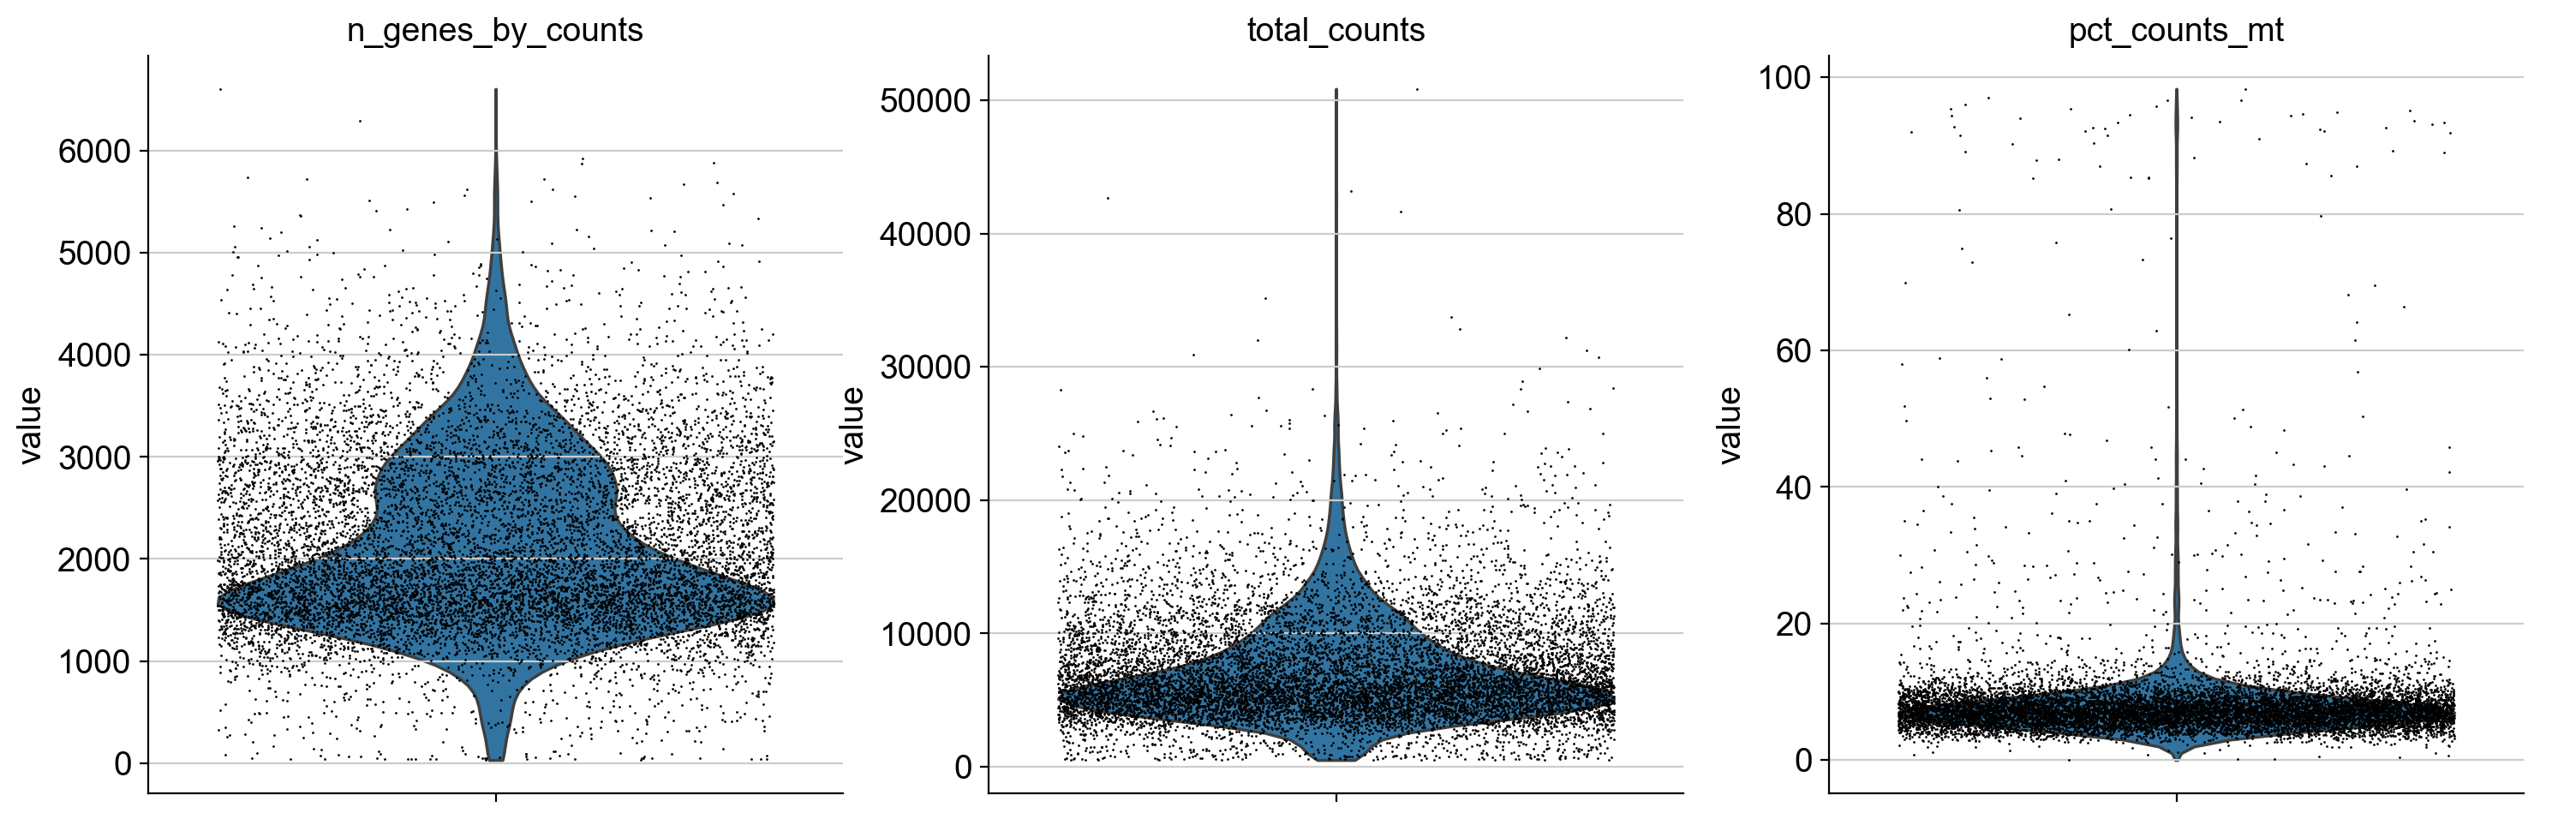

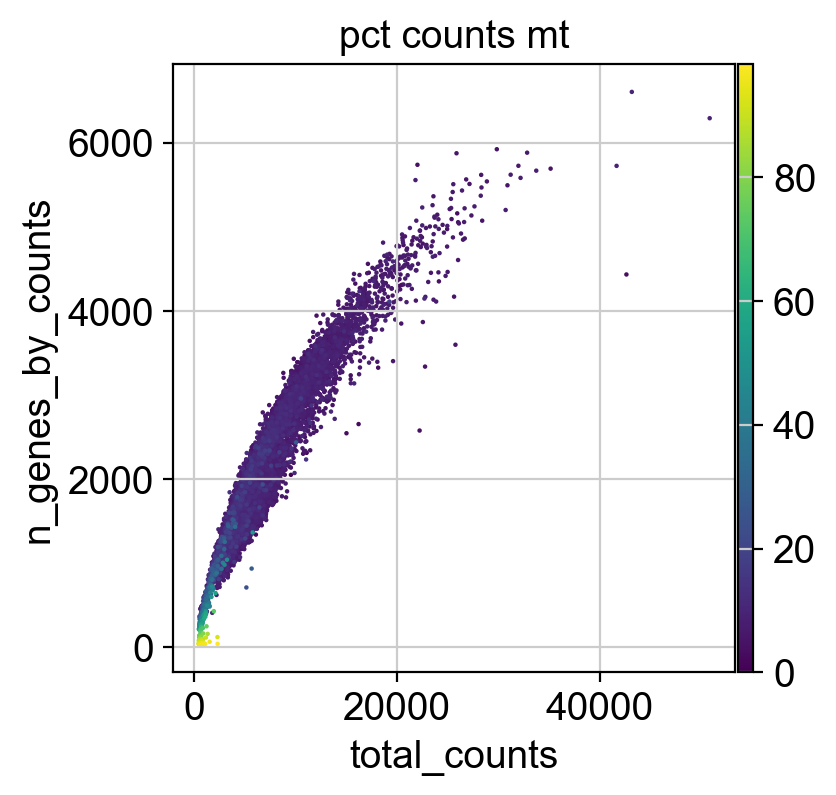

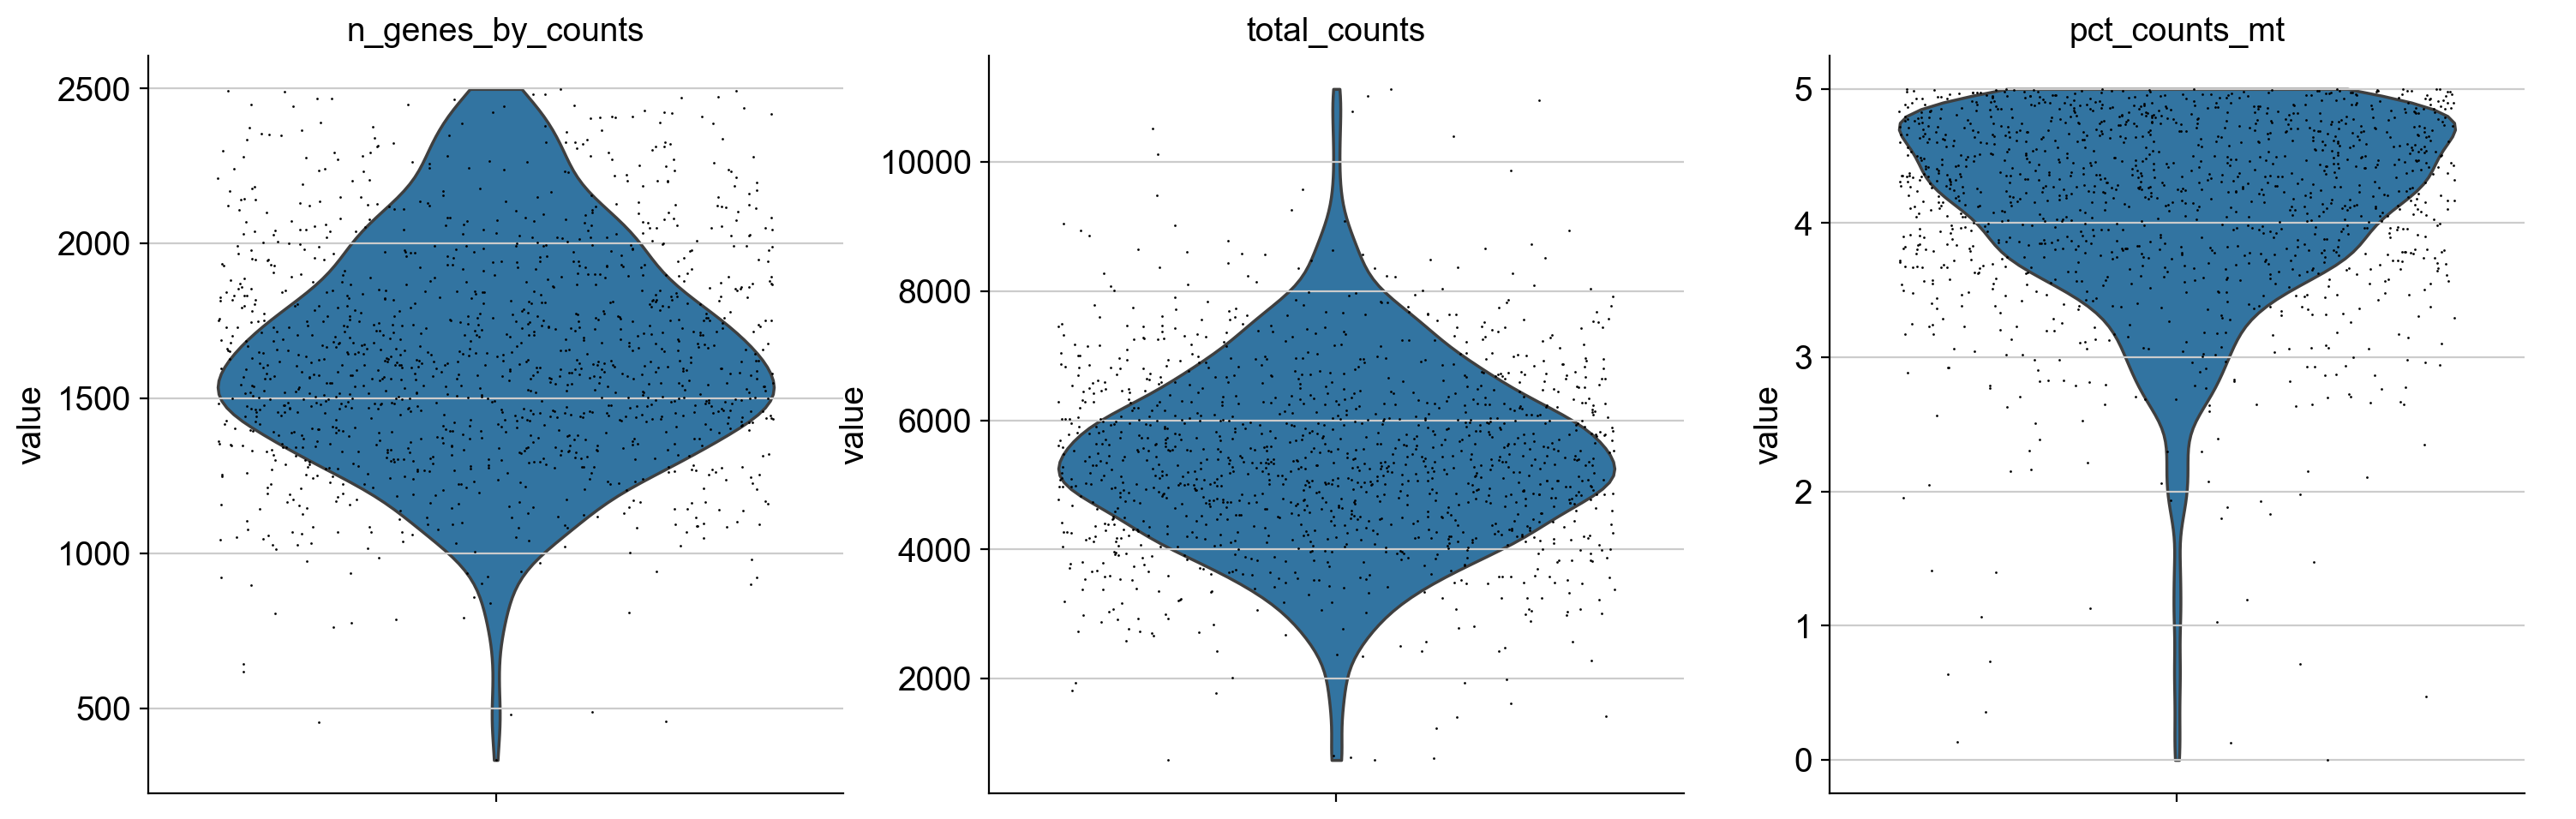

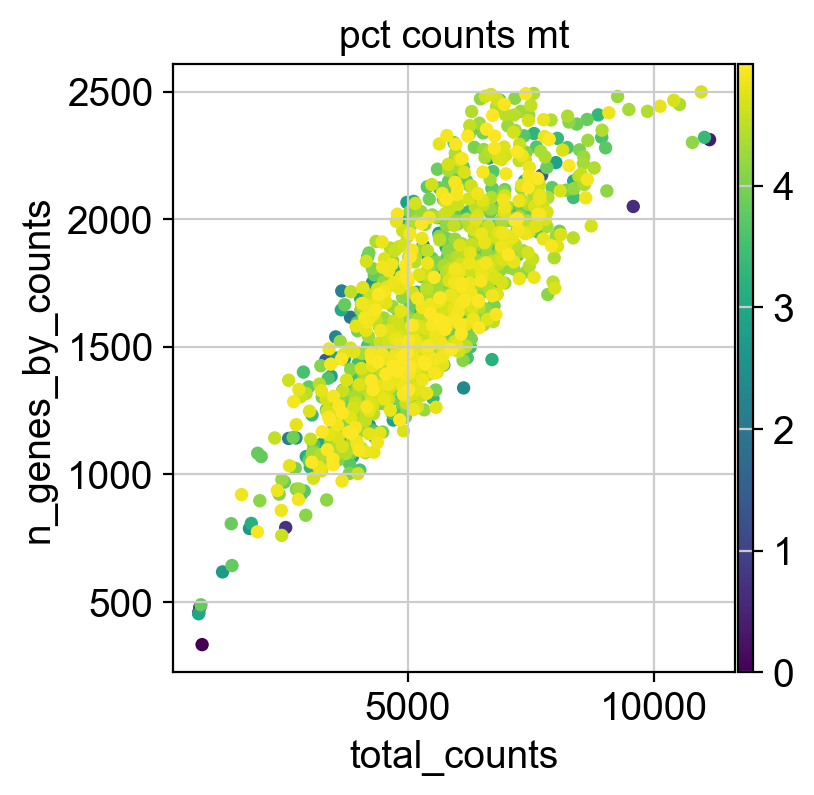

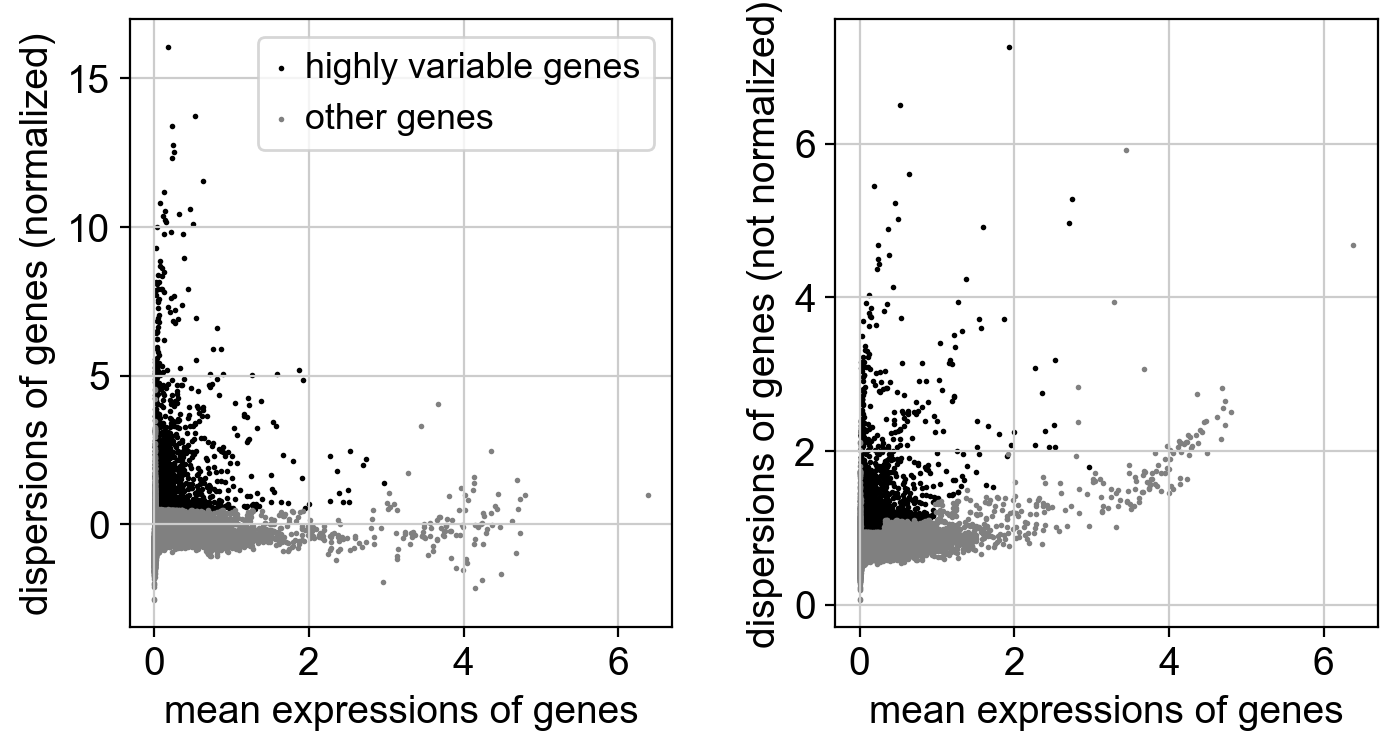

Preprocessing complete.


c:\Users\mohak\AppData\Local\Programs\Python\Python312\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [3]:
    #1 Preprocessing

    # Configuration
    sc.set_figure_params(dpi=100, facecolor='white', frameon=False)
    sc.settings.verbosity = 0 # Silent
    plot_output_folder = "C:/Users/mohak/Desktop/scRNA_analysis/plots/preprocessing"
    os.makedirs(plot_output_folder, exist_ok=True)
    sc.settings.figdir = plot_output_folder

    #Data file path
    data_file_path = "C:/Users/mohak/Desktop/Cell matrix.h5"

    #Loading the Data
    adata = sc.read_10x_h5(data_file_path)
    adata.var_names_make_unique()

    #Calculating Metrics
    adata.var['mt'] = adata.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

    #Visualizing Metrics (Pre-filtering) - Plots saved to 'figdir'
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True, save="_qc_violin_pre.png")
    sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt', save="_qc_scatter_pre.png")

    #Filtering Cells and Genes
    adata = adata[
        (adata.obs['n_genes_by_counts'] > 200) &
        (adata.obs['n_genes_by_counts'] < 2500) &
        (adata.obs['pct_counts_mt'] < 5.0)
    ].copy()
    sc.pp.filter_genes(adata, min_cells=3)

    #Visualizing Metrics (Post-filtering) - Plots saved to 'figdir'
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True, save="_qc_violin_post.png")
    sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt', save="_qc_scatter_post.png")

    #Normalization and Log-transformation
    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    #Identifying Highly Variable Genes
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    sc.pl.highly_variable_genes(adata, save="_highly_variable_genes.png")
    adata = adata[:, adata.var.highly_variable].copy()

    #Scaling the Data
    sc.pp.scale(adata, max_value=10)
    print("Preprocessing complete.")


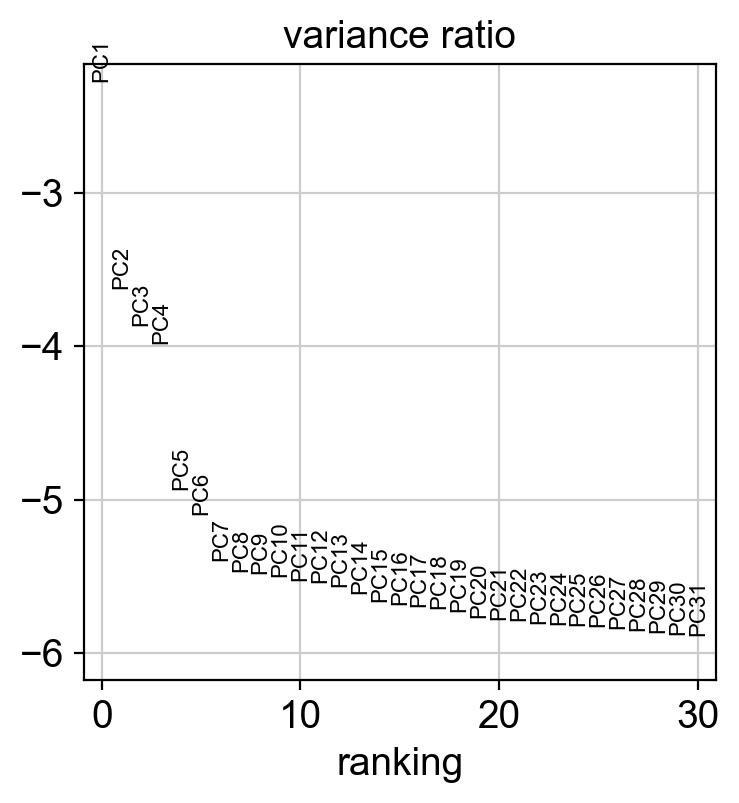

c:\Users\mohak\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


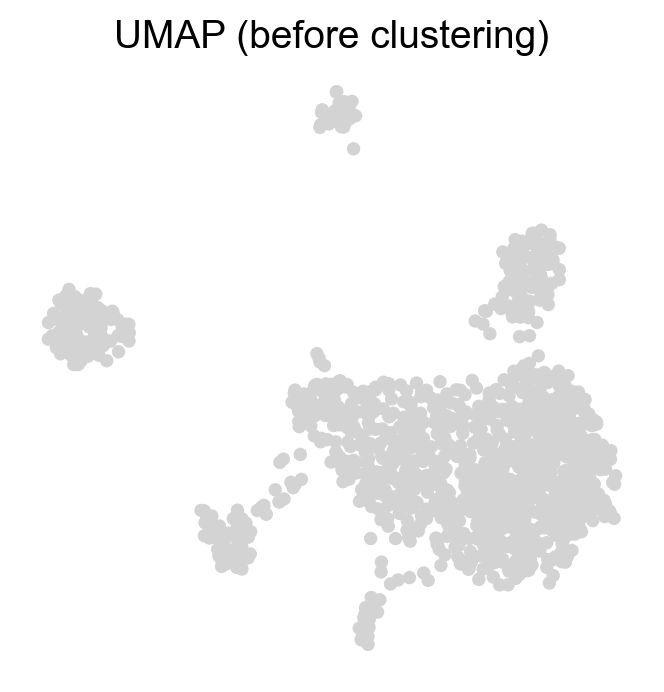

C:\Users\mohak\AppData\Local\Temp\ipykernel_23676\1312604487.py:16: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


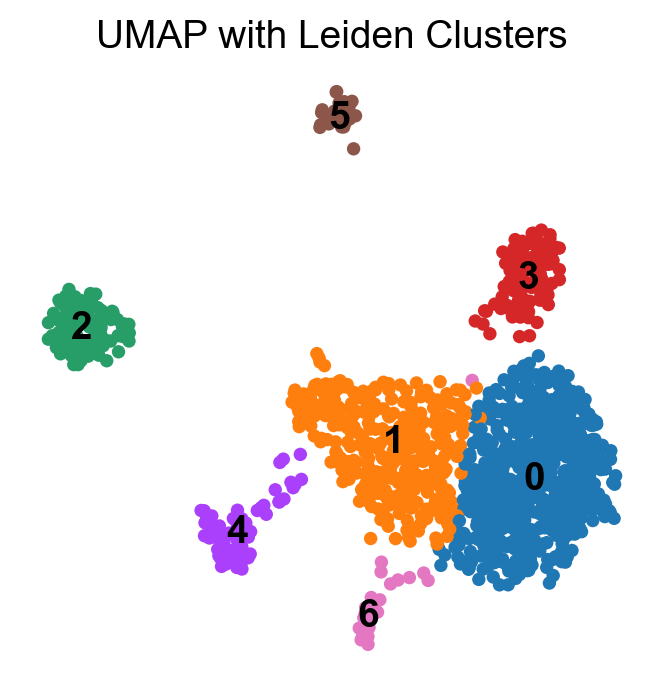

Dimensionality Reduction and Clustering Complete.


In [4]:
#2. UMAP and Leiden Clustering

save_file_path = "C:/Users/mohak/Desktop/UMAP and Clustering Plots"
# A. Principal Component Analysis (PCA)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, save="_pca_variance_ratio.png") #Elbow Plot

# B. Computing the Nearest-Neighbor Graph
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

# C. UMAP Embedding
sc.tl.umap(adata)
sc.pl.umap(adata, save="_umap_initial.png", title="UMAP (before clustering)")

# D. Leiden Clustering
sc.tl.leiden(adata, resolution=0.5)

# E. Visualizing UMAP with Clusters
sc.pl.umap(adata, color='leiden', legend_loc='on data', save="_umap_leiden.png", title="UMAP with Leiden Clusters")
print("Dimensionality Reduction and Clustering Complete.")


Diagnostic: Actual Leiden Cluster Categories
Actual Leiden clusters are: ['0', '1', '2', '3', '4', '5', '6']
End Diagnostic


c:\Users\mohak\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\mohak\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\mohak\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\mohak\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\mohak\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: inv

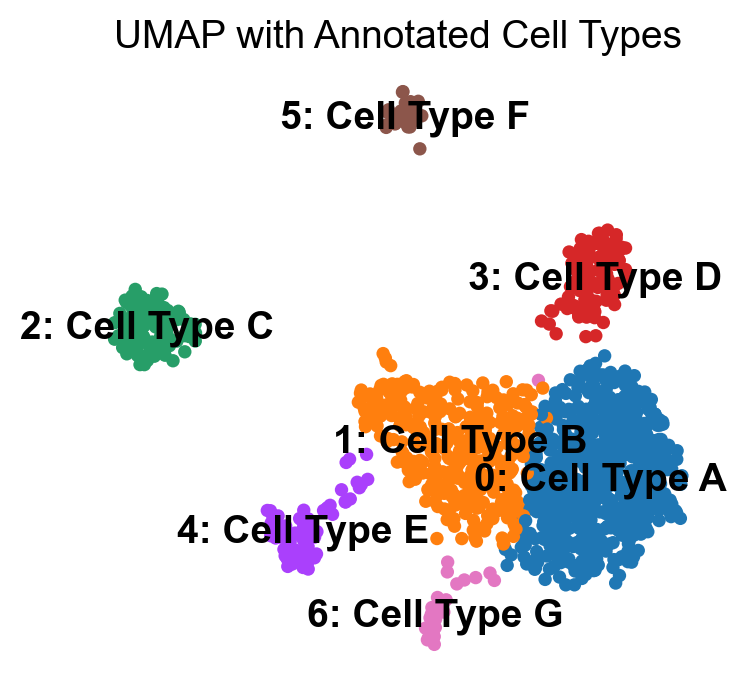

Marker gene finding and cluster annotation complete (review plots and manual names).


In [5]:
#3 Finding the Clusters in the data and naming them 
# Ensure rank_genes_groups has run from step 4
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', rankby_abs=True, tie_correct=True)

# Diagnostic: Print the actual categories
print("\nDiagnostic: Actual Leiden Cluster Categories")
actual_leiden_categories = adata.obs['leiden'].cat.categories.tolist()
print(f"Actual Leiden clusters are: {actual_leiden_categories}")
print("End Diagnostic")

new_cluster_names = [
    "0: Cell Type A",
    "1: Cell Type B",
    "2: Cell Type C", 
    "3: Cell Type D",
    "4: Cell Type E",
    "5: Cell Type F",
    "6: Cell Type G"
]


adata.rename_categories('leiden', new_cluster_names) 
sc.pl.umap(adata, color='leiden', legend_loc='on data', save="_umap_annotated.png", title="UMAP with Annotated Cell Types", show=True)
plt.show()
print("Marker gene finding and cluster annotation complete (review plots and manual names).")

In [6]:
# Getting the top 10 marker genes for each cluster
# This will print a table where each column is a cluster (0, 1, 2, etc.)
# and the rows are the top genes for that cluster.
print("\nTop 10 Marker Genes for Each Cluster")
marker_genes_df = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)
print(marker_genes_df)



Top 10 Marker Genes for Each Cluster
  0: Cell Type A 1: Cell Type B 2: Cell Type C 3: Cell Type D 4: Cell Type E  \
0         S100A4          ITGB1           CSTA           CD8B           GZMH   
1       SH3BGRL3          CRIP1         MS4A6A      LINC02446           CCL4   
2          AHNAK            MAF           CD14           CD8A         FGFBP2   
3          ANXA2           IL32           FGL2          KLRK1          KLRD1   
4         LGALS1          KLRB1          CEBPD          CRTAM           NKG7   
5          ITGB1         GPR183           VCAN          S100B           CST7   
6        S100A11          ANXA1          DUSP6          KLRC4           GNLY   
7          CLIC1        S100A11           CD36           CTSW           GZMB   
8          MYO1F        TNFRSF4           NCF2     AC022075.1           CCL5   
9          HLA-A          HLA-A       TMEM176B        S100A11           GZMA   

  5: Cell Type F 6: Cell Type G  
0          MS4A1          FOXP3  
1           C


Diagnostic: Actual Leiden Cluster Categories
Actual Leiden clusters are: ['0: Cell Type A', '1: Cell Type B', '2: Cell Type C', '3: Cell Type D', '4: Cell Type E', '5: Cell Type F', '6: Cell Type G']
End Diagnostic


c:\Users\mohak\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\mohak\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\mohak\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\mohak\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\mohak\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: inv

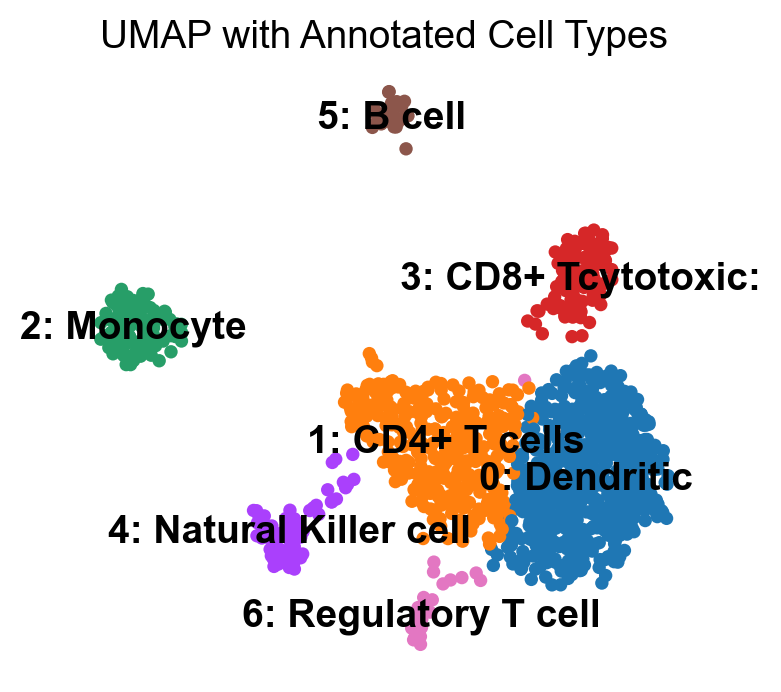

Marker gene finding and cluster annotation complete (review plots and manual names).


In [7]:
# Renaming the Clusters in the data and naming them 
# Ensure rank_genes_groups has run from step 4
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', rankby_abs=True, tie_correct=True)

# Diagnostic: Print the actual categories
print("\nDiagnostic: Actual Leiden Cluster Categories")
actual_leiden_categories = adata.obs['leiden'].cat.categories.tolist()
print(f"Actual Leiden clusters are: {actual_leiden_categories}")
print("End Diagnostic")

new_cluster_names = [  
    "0: Dendritic",  
    "1: CD4+ T cells",
    "2: Monocyte",
    "3: CD8+ Tcytotoxic:",
    "4: Natural Killer cell",
    "5: B cell",
    "6: Regulatory T cell"
]


adata.rename_categories('leiden', new_cluster_names) 
sc.pl.umap(adata, color='leiden', legend_loc='on data', save="_umap_annotated.png", title="UMAP with Annotated Cell Types", show=True)
plt.show()
print("Marker gene finding and cluster annotation complete (review plots and manual names).")

In [8]:
#Saving annotated data
adata.write("C:/Users/mohak/Desktop/adata.h5ad")
print("Saved")

Saved
